__Purpose:__ Introduce Personalized Federated Learning, specifically by implementing APFL on our dataset and then trying other methods.
<br>
1. We are still assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

D_0_7 = np.random.rand(2,7)

# Testing APFL

Testing the APFL Implementation

In [3]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0, global_method='APFL', verbose=True) for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL, num_steps=10)

global_model_APFL.execute_FL_loop()

ID: 0, L: 89.98508334747586
ID: 0, eta_t: 0.0013891190016996758

ID: 5, L: 52.655224378775685
ID: 5, eta_t: 0.002373933126833898



In [4]:
for i in range(20):
    global_model_APFL.execute_FL_loop()
    #print(f"ROUND {i}")
    #for my_client in global_model_APFL.chosen_clients_lst:
    #    # So since APFL sets the chosen_clients_lst AFTER it runs instead of before each iter, the following line can actually fail...
    #    #print(round(np.linalg.norm(( my_client.F@np.transpose(my_client.F) + my_client.alphaD*np.identity(my_client.F.shape[0]))), 3))
    #print(global_model_APFL.current_round)
    #print(len(global_model_APFL.global_error_log))
    #print()

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891188813416353

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.0023739327714690558

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891187607384418

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.0023739324192468083

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891186401352692

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.0023739320670246645

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891185195321174

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.0023739317148026256

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891183989289864

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.0023739313625806913

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891182783258764

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.0023739310103588615

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891181577227875

ID: 5, L: 52.655224448477945
ID: 5, eta_t: 0.002373930658137136

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013891180371197194

ID: 5, L: 52.655224

In [5]:
for i in range(num_participants):
    try:
        user_c0_APFL[i].F.shape
        # If it works then break the loop
        break
    except AttributeError:
        pass

print(i)

0


In [6]:
#i = 0
# This should be the same i as the above loop

print(f"F.shape: {user_c0_APFL[i].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[i].F)}")
print(f"Sum: {np.sum((user_c0_APFL[i].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[i].F)**2)}")

F.shape: (7, 600)
Norm: 11.603236878977487
Sum: -0.8907682682368048
**2 Sum: 134.63510606966324


In [7]:
print("Decs")
print(user_c0_APFL[i].local_w)
print(user_c0_APFL[i].global_w)
diff = user_c0_APFL[i].local_w - user_c0_APFL[i].global_w
print(diff)
print()
print("Gradient")
out = gradient_cost_l2(user_c0_APFL[i].F, user_c0_APFL[i].mixed_w, user_c0_APFL[i].H, user_c0_APFL[i].V, user_c0_APFL[i].learning_batch, user_c0_APFL[i].alphaF, user_c0_APFL[i].alphaD, Ne=7)
print(out.shape)
print(out)

Decs
[[0.34972726 0.89982522 0.41001077 0.07452822 0.55257348 0.49938225
  0.32370665]
 [0.16255044 0.82532832 0.16004564 0.79299667 0.5678978  0.64894141
  0.36683354]]
[[0.34971064 0.89978403 0.40999265 0.07452493 0.5525491  0.49936023
  0.32369238]
 [0.16254272 0.82529055 0.16003856 0.79296167 0.56787274 0.64891279
  0.36681737]]
[[1.66234977e-05 4.11829990e-05 1.81193876e-05 3.28696927e-06
  2.43832080e-05 2.20262287e-05 1.42713832e-05]
 [7.72140585e-06 3.77733295e-05 7.07295207e-06 3.50009180e-05
  2.50591992e-05 2.86227137e-05 1.61726372e-05]]

Gradient
(14,)
[-0.00077105 -0.00177317 -0.00080241 -0.00014941 -0.00108334 -0.00098212
 -0.00064244 -0.00033562 -0.0017302  -0.00031682 -0.00156233 -0.00111742
 -0.00127308 -0.00071844]


In [8]:
np.inner(diff.flatten(), out.flatten())

-3.590189184048721e-07

Run loop

In [9]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.000631827229004434

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.005823148402780444

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318272040540821

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.005823146283465132

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.000631827179103732

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.005823144164151364

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.000631827154153384

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.0058231420448391375

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.000631827129203038

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.005823139925528454

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318271042526939

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.0058231378062193135

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318270793023517

ID: 8, L: 21.465879022881094
ID: 8, eta_t: 0.005823135686911715

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318270543520116

ID: 8, L: 21.46587902288109

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028197144561975945

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318251331817376

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.002819713959273331

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318251082315511

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.002819713462349243

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318250832813668

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.00281971296542533

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318250583311842

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028197124685015924

ID: 4, L: 25.584697178410433
ID: 4, eta_t: 0.0048855674321785485

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.0028013693490872168

ID: 4, L: 25.584697178410433
ID: 4, eta_t: 0.0048855659403809325

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.0028013688586079133

ID: 4, L: 25.584697178410433
ID: 4, eta_t: 0.004885564448584229

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.002801368368128782

ID: 4, L: 25

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170295217217084

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.002801336487353621

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.001017029457074897

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.0028013359968858246

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318232619232223

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.0028013350159507475

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318232369731836

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.002801334525483466

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318232120231469

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.002801334035016357

ID: 3, L: 197.8387218316889
ID: 3, eta_t: 0.0006318231870731122

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.0028013335445494195

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.000719732342097089

ID: 10, L: 44.62016789333621
ID: 10, eta_t: 0.0028013330540826533

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.0007197323097211752

ID: 10, L: 44.

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: overflow encountered in multiply
  self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1]) * self.global_w
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:41: RuntimeWarning: invalid value encountered in matmul
  term1 = (np.linalg.norm((D@F + H@Vminus - Vplus))**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:23: RuntimeWarning: invalid value encountered in matmul
  return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: invalid value encountered in subtract
  self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1]) * self.global_w
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: overflow encountered in multiply
  se

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.0007197316945793663

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.002819664764638229

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.0007197316622035107

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028196642677314797

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.0007197316298276581

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028196637708249065

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.0007197315974518083

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028196632739185077

ID: 3, L: 173.67422922476848
ID: 3, eta_t: 0.0007197315650759614

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028196627770122836

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.001389093675729332

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954768198127948

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013890935551305148

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954768044692154

ID: 0, L: 89.98508333159384
ID: 0, eta_t: 0.0013890934345317186

ID: 1, L: 

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170228631433062

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.001814724589131479

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170227984973412

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.001814724383304919

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170227338513844

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.0018147241774784057

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.001017022669205436

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.0018147239716519393

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170226045594958

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.0018147237658255192

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170225399135637

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.0018147235599991459

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.00101702247526764

ID: 13, L: 68.8787802077714
ID: 13, eta_t: 0.0018147233541728192

ID: 7, L: 122.9055627428728
ID: 7, eta_t: 0.0010170224106217244

ID: 13, L: 68.878780207

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:23: RuntimeWarning: invalid value encountered in matmul
  return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:23: RuntimeWarning: invalid value encountered in matmul
  return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())


ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.003185053558574698

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028195723429960814

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.0031850529245394388

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028195718461219064

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.003185052290504432

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.002819571349247907

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.003185051656469677

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028195708523740823

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.0031850510224351748

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.002819570355500433

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.0031850503884009247

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.0028195698586269587

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.003185049754366928

ID: 12, L: 44.32990960423186
ID: 12, eta_t: 0.002819569361753659

ID: 4, L: 39.242753177639045
ID: 4, eta_t: 0.0031850491203331828

ID: 12, L:

ID: 8, L: 26.943378843001994
ID: 8, eta_t: 0.004638702357099701

ID: 2, L: 177.67356144501142
ID: 2, eta_t: 0.0007035222984690091

ID: 8, L: 26.943378843001994
ID: 8, eta_t: 0.0046387010122526185

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954725236476642

ID: 9, L: 37.44341334263364
ID: 9, eta_t: 0.0033380288913854744

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954725083043508

ID: 9, L: 37.44341334263364
ID: 9, eta_t: 0.0033380281949833145

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954724929610384

ID: 9, L: 37.44341334263364
ID: 9, eta_t: 0.003338027498581445

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954724776177269

ID: 9, L: 37.44341334263364
ID: 9, eta_t: 0.003338026802179867

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954724622744164

ID: 9, L: 20.147749514937857
ID: 9, eta_t: 0.006202976259710122

ID: 1, L: 252.28058758562725
ID: 1, eta_t: 0.0004954724469311069

ID: 9, L: 20.147749514937857
ID: 9, eta_t: 0.006202973854903899

ID: 1, L: 252.28058

ID: 0, L: 227.7982557339147
ID: 0, eta_t: 0.0005487203531451654

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015035100776710614

ID: 0, L: 227.7982557339147
ID: 0, eta_t: 0.0005487203343267894

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015035099363871652

ID: 0, L: 227.7982557339147
ID: 0, eta_t: 0.0005487203155084148

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015035097951032954

ID: 0, L: 227.7982557339147
ID: 0, eta_t: 0.0005487202966900414

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.001503509653819452

ID: 0, L: 227.7982557339147
ID: 0, eta_t: 0.0005487202778716693

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015035095125356356

ID: 0, L: 227.7982557339147
ID: 0, eta_t: 0.0005487202590532985

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015035093712518453

ID: 2, L: 177.67356144501142
ID: 2, eta_t: 0.0007035194525546809

ID: 10, L: 37.492557526893926
ID: 10, eta_t: 0.0033335914342593745

ID: 2, L: 177.67356144501142
ID: 2, eta_t: 0.000703519421620956

ID: 10, L:

ID: 4, L: 36.77408123943727
ID: 4, eta_t: 0.0033986429313505703

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015034952430069235

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.0008367349056646178

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015034949604447333

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.0008367348619067887

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.001503494819163678

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.0008367348181489642

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015034946778826495

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.0008367347743911442

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015034945366016472

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.0008367347306333288

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.001503494395320672

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.000836734686875518

ID: 12, L: 83.13429989814908
ID: 12, eta_t: 0.0015034942540397228

ID: 6, L: 149.38488577757892
ID: 6, eta_t: 0.0008367346431177118

ID: 12,

ID: 9, L: 15.152174927676064
ID: 9, eta_t: 0.00824630734293459

ID: 4, L: 58.46992125885346
ID: 4, eta_t: 0.002137627136185915

ID: 9, L: 15.152174927676064
ID: 9, eta_t: 0.008246303092837732

ID: 4, L: 58.46992125885346
ID: 4, eta_t: 0.002137626850595342

ID: 9, L: 15.152174927676064
ID: 9, eta_t: 0.008246298842745253

ID: 4, L: 58.46992125885346
ID: 4, eta_t: 0.002137626565004846

ID: 9, L: 15.152174927676064
ID: 9, eta_t: 0.008246294592657155

ID: 4, L: 58.46992125885346
ID: 4, eta_t: 0.0021376262794144257

ID: 9, L: 15.152174927676064
ID: 9, eta_t: 0.00824629034257344

ID: 4, L: 58.46992125885346
ID: 4, eta_t: 0.002137625993824082

ID: 9, L: 15.152174927676064
ID: 9, eta_t: 0.008246286092494105

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089364989784686

ID: 10, L: 26.11862366528341
ID: 10, eta_t: 0.004784725010635617

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089363370932952

ID: 10, L: 26.11862366528341
ID: 10, eta_t: 0.004784723579786456

ID: 8, L: 24.55484123571901
ID:

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.0018629115009271362

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089203109708859

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.0018629112840247077

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089201490960106

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.0018629110671223295

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089199872212382

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.001862910850220002

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089198253465688

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.001862910633317725

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089196634720025

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.0018629104164154988

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.00508919501597539

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.001862910199513323

ID: 8, L: 24.55484123571901
ID: 8, eta_t: 0.005089193397231785

ID: 3, L: 67.09230810334807
ID: 3, eta_t: 0.0018629099826111973

ID: 8, L: 24.55484123571901
ID: 8, e

ID: 10, L: 40.23687468387285
ID: 10, eta_t: 0.003105997025169625

ID: 11, L: 87.06430362294041
ID: 11, eta_t: 0.0014355909731852098

ID: 10, L: 40.23687468387285
ID: 10, eta_t: 0.003105996422218647

ID: 11, L: 87.06430362294041
ID: 11, eta_t: 0.001435590844377631

ID: 10, L: 40.23687468387285
ID: 10, eta_t: 0.0031059958192679034

ID: 11, L: 87.06430362294041
ID: 11, eta_t: 0.0014355907155700757

ID: 10, L: 40.23687468387285
ID: 10, eta_t: 0.0031059952163173935

ID: 11, L: 87.06430362294041
ID: 11, eta_t: 0.0014355905867625431

ID: 10, L: 40.23687468387285
ID: 10, eta_t: 0.003105994613367118

ID: 11, L: 87.06430362294041
ID: 11, eta_t: 0.001435590457955034

ID: 5, L: 120.008856094909
ID: 5, eta_t: 0.0010415212483207527

ID: 8, L: 26.60628616405602
ID: 8, eta_t: 0.004696743555039885

ID: 5, L: 120.008856094909
ID: 5, eta_t: 0.0010415211805228503

ID: 8, L: 26.60628616405602
ID: 8, eta_t: 0.004696742176327789

ID: 5, L: 120.008856094909
ID: 5, eta_t: 0.0010415211127249567

ID: 8, L: 26.60

In [10]:
user_c0_APFL[0].adap_alpha[:22]

[0.01,
 0.01,
 0.01,
 0.010000000062341897,
 0.010000000187025135,
 0.010000000374049158,
 0.01000000062341341,
 0.010000000935117336,
 0.01000000130916038,
 0.010000001745541985,
 0.009833365165926136,
 0.0071402169243553444,
 0.004439304794759242,
 0.0017306064445287823,
 -0.0009859005230217054,
 -0.003710238568837802,
 -0.006442430218308803,
 -0.009182498061452046,
 -0.011930464753097765,
 nan,
 nan,
 nan]

In [11]:
print(f"F.shape: {user_c0_APFL[0].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[0].F)}")
print(f"Sum: {np.sum((user_c0_APFL[0].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[0].F)**2)}")

F.shape: (7, 600)
Norm: 14.484250499208184
Sum: -0.7574367265327666
**2 Sum: 209.79351252381258


In [12]:
print(user_c0_APFL[0].local_w)
print(user_c0_APFL[0].global_w)
diff = user_c0_APFL[0].local_w - user_c0_APFL[0].global_w
print(diff)
out = gradient_cost_l2(user_c0_APFL[0].F, user_c0_APFL[0].mixed_w, user_c0_APFL[0].H, user_c0_APFL[0].V, user_c0_APFL[0].learning_batch, user_c0_APFL[0].alphaF, user_c0_APFL[0].alphaD, Ne=7)
print(out.shape)
print(out)

[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
(14,)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [13]:
np.inner(diff.flatten(), out.flatten())

nan

Plot

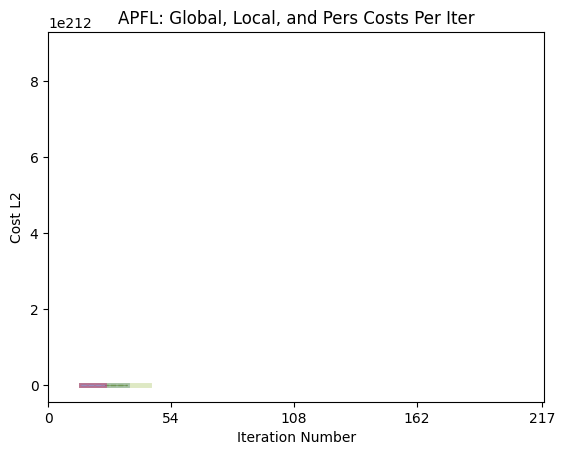

In [14]:
condensed_external_plotting(user_c0_APFL, 'local', pers_error=True, show_update_change=False, custom_title="APFL: Global, Local, and Pers Costs Per Iter")

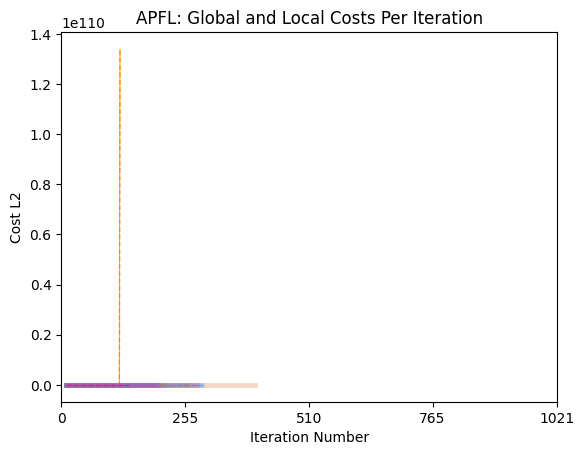

In [15]:
condensed_external_plotting(global_model_APFL, 'global', pers_error=True, show_update_change=False, custom_title="APFL: Global and Local Costs Per Iteration")

In [16]:
global_model_APFL.current_round

1021

In [17]:
#client_loss.append(input_data.global_error_log[j][i][2])
len(global_model_APFL.global_error_log)

2347

In [18]:
len(global_model_APFL.local_error_log)

2347

In [19]:
len(global_model_APFL.personalized_error_log)

2347

Re-running but with input learning rate (eta) of 0.00001

In [39]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', input_eta=True, num_steps=10, eta=0.00001, delay_scaling=0, global_method='APFL') for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL, num_steps=10)

global_model_APFL.execute_FL_loop()

In [40]:
for i in range(20):
    global_model_APFL.execute_FL_loop()

In [41]:
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: invalid value encountered in subtract
  self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1]) * self.global_w
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: overflow encountered in multiply
  self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1]) * self.global_w
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:41: RuntimeWarning: invalid value encountered in matmul
  term1 = (np.linalg.norm((D@F + H@Vminus - Vplus))**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:23: RuntimeWarning: invalid value encountered in matmul
  return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: overflow encountered in multiply
  se

(Current Local Round, Current Local Update)
(207, 14)
(135, 12)
(36, 10)
(135, 12)
(135, 12)
(144, 12)
(171, 13)
(72, 11)
(81, 11)
(135, 12)
(162, 13)
(154, 13)
(145, 12)
(126, 12)


In [42]:
user_c0_APFL[0].adap_alpha[:22]

[0.01,
 0.01066928255139192,
 -5.410666567767182,
 -40.54327957520267,
 -268.21787642470883,
 -1743.6481337953587,
 -11305.076577914788,
 -73267.28004238081,
 -474809.1688065689,
 -3076965.4195625717,
 -4369879112.567737,
 -1569510737646161.0,
 4.4832534891700293e+24,
 -1.345449892627524e+49,
 3.391001694431186e+107,
 -6.476928205568097e+248,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

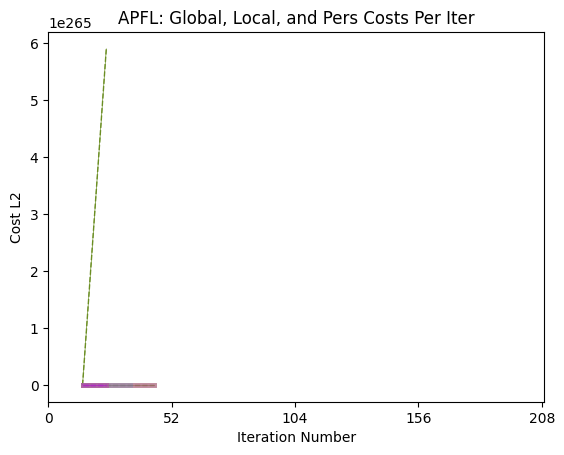

In [43]:
condensed_external_plotting(user_c0_APFL, 'local', pers_error=True, show_update_change=False, custom_title="APFL: Global, Local, and Pers Costs Per Iter")

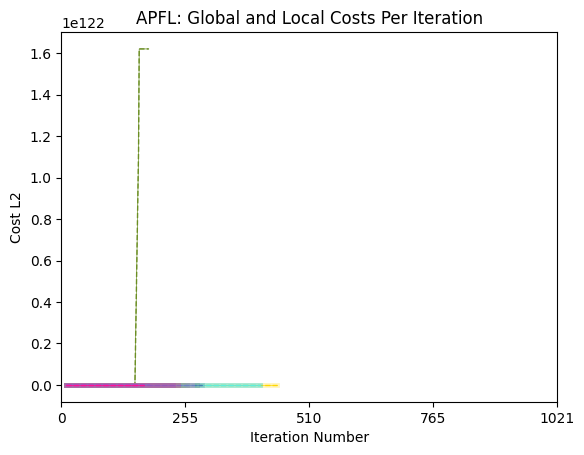

In [44]:
condensed_external_plotting(global_model_APFL, 'global', pers_error=True, show_update_change=False, custom_title="APFL: Global and Local Costs Per Iteration")

In [26]:
assert(1==0)

AssertionError: 

# DEVELOPMENT

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
1. APFL
1. Cesar/Taha: AFL
1. Cesar/Taha: PersA-FL MAML
1. Cesar/Taha: PersA-FL ME
1. PFA: PP F Adaptation for Effective Model Personalization
1. Pers RT FL for Epileptic Seizure Detection
1. An Efficient Framework for Clustered FL
1. Pers FL with DP
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. Loss.backward() does not update the weights, only computes the gradients.  The graph is used by loss.backward() to compute gradients.  In pseudo-code: x.grad += dloss/dx

optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

optimizer.zero_grad() and optimizer.step() do not affect the graph of autograd objects. They only touch the model’s parameters and the parameter’s grad attributes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

In [ ]:
#python run_mpi.py -f -ft apfl -n 10 -d mnist -lg 0.1 -b 50 -c 20 -k 1.0 -fs local_step -l 10 -r 2 -pa 0.5 -fp
#'--num_epochs': args.num_epochs_per_comm * args.num_comms,

# num_epochs_per_comm=1
# num_clients=20
# batch_size=50
# num_comms=100
# lr_gamma=1.0
# lr_mu = 1

## Personalized Asynchronous Federated Learning (Taha+Cesar)
> https://arxiv.org/pdf/2210.01176.pdf

In [ ]:
assert(1==0)

Basic AFL
> My code is not configured to run this way, although this way is the most realistic (server waits for client responses).  Ideally would have some way to weight different clients if there are some that are spamming, or generally just faster than others and contributing more.

In [ ]:
# Repeat until converged...
# how do you know in a decentralized way lol
#if self.update_recieved:
#    self.w -= self.beta*self.latest_update

Personalized AFL
> 3 Methods (1 is just vanilla AFL)

In [ ]:
#input: number of local steps Q, local stepsize η, MAML stepsize α, Moreau Envelope (ME) regularization parameter λ, minimum batch size b, estimation error ν.

# Do client selection

for my_client in self.chosen_clients_lst:
    my_client.global_w = self.w
    for q in range(Q):
        #"Sample a data batch D_{i, q} from distribution p_i"
        
        # OPTION A (AFL) --> Just what is shown in the cell above
        if self.global_method=='AFL':
            # Server doesn't have client's grad input info... eg FDHV
            # In their model/code, does the client send the params or the new weight?
            
            # Eqn 5 is the original
            # Eqn 9 is the biased estimation of 5, shown below
            self.w -= self.eta*gradient_cost_l2(self.F,self.D,self.H,self.V,self.learning_batch,self.alphaF,self.alphaD)
        # OPTION B (PersA-FL: MAML)
        elif self.global_method=='PersA_FL_MAML':
            #"Sample 2 databatches from distribution p_i"
            # I have no idea what these terms are lol
            # I don't think I can use the analytical cost funcs here either now
            self.w -= self.eta*(I-alpha*Hessian(self.w, D_dd))*grad(self.w-alpha*grad(D_d), D)
        # OPTION C (PersA-FL: ME)
        elif self.global_method=='PersA_FL_ME':
            self.h = f(theta_i, D) + lambda*0.5*(np.linalg.norm(theta_i - self.w)^2)
            #"Minimize h wrt theta_i up to accuracy level v to find theta_tilde_i"
            #np.linalg.norm(grad_h(theta_tilde_i(self.w), self.w, D)) <= v
            #scipy.minimize(...)
            self.w -= self.eta*lambda*(self.w - theta_tilde_i(self.w))
        
        # ELSE
        else:
            print(f'Global method {self.method} not defined, please select one from the following: {self.implemented_global_training_methods}')
delta_i = self.w_i_0 - self.w_i_Q
# client i broadcasts delta_i to the server
#"Repeat until not interrupted by the server"